In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def CTfunction(a, glauert = False):
    """
    This function calculates the thrust coefficient as a function of induction factor 'a'
    'glauert' defines if the Glauert correction for heavily loaded rotors should be used; default value is false
    """
    CT = np.zeros(np.shape(a))
    CT = 4*a*(1-a)  
    if glauert:
        CT1=1.816;
        a1=1-np.sqrt(CT1)/2;
        CT[a>a1] = CT1-4*(np.sqrt(CT1)-1)*(1-a[a>a1])
    
    return CT
  
    
def ainduction(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    

    
    corrected_indeces = np.invert((CT<CT2) & (CT>-CT2))
    
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[(CT<CT2) & (CT>=0) ] = 0.5-0.5*np.sqrt(1-CT[(CT<CT2) & (CT>=0)])
    a[(CT<0) & (CT>-CT2) ] = -(0.5-0.5*np.sqrt(1+CT[(CT<0) & (CT>-CT2)]))    
    a[CT<=-CT2] = -(1 + (-CT[CT<=-CT2]-CT1)/(4*(np.sqrt(CT1)-1)))


    return a

def ainduction_old(CT):
    """
    This function calculates the induction factor 'a' as a function of thrust coefficient CT 
    including Glauert's correction
    """
    a = np.zeros(np.shape(CT))
    CT1=1.816;
    CT2=2*np.sqrt(CT1)-CT1
    a[CT>=CT2] = 1 + (CT[CT>=CT2]-CT1)/(4*(np.sqrt(CT1)-1))
    a[CT<CT2] = 0.5-0.5*np.sqrt(1-CT[CT<CT2])
    return a

def PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, axial_induction):
    """
    This function calcualte steh combined tip and root Prandtl correction at agiven radial position 'r_R' (non-dimensioned by rotor radius), 
    given a root and tip radius (also non-dimensioned), a tip speed ratio TSR, the number lf blades NBlades and the axial induction factor
    """
    temp1 = -NBlades/2*(tipradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Ftip = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Ftip[np.isnan(Ftip)] = 0
    temp1 = NBlades/2*(rootradius_R-r_R)/r_R*np.sqrt( 1+ ((TSR*r_R)**2)/((1-axial_induction)**2))
    Froot = np.array(2/np.pi*np.arccos(np.exp(temp1)))
    Froot[np.isnan(Froot)] = 0
    return Froot*Ftip, Ftip, Froot

def loadBladeElement(vnorm, vtan, r_R, chord, twist, polar_alpha, polar_cl, polar_cd, rho):
    """
    calculates the load in the blade element
    """
    vmag2 = vnorm**2 + vtan**2
    inflowangle = np.arctan2(vnorm,vtan)
    alpha = inflowangle*180/np.pi - twist
    
    #print(inflowangle*180/np.pi,twist,alpha)

    cl = np.interp(alpha, polar_alpha, polar_cl)
    cd = np.interp(alpha, polar_alpha, polar_cd)
    lift = 0.5*rho*vmag2*cl*chord
    drag = 0.5*rho*vmag2*cd*chord
    fnorm = lift*np.cos(inflowangle)+drag*np.sin(inflowangle)
    ftan = lift*np.sin(inflowangle)-drag*np.cos(inflowangle)
    gamma = 0.5*rho*np.sqrt(vmag2)*cl*chord
    return fnorm , ftan, gamma, inflowangle*180/np.pi, alpha, cl, np.sqrt(vmag2)

def solveStreamtube(Uinf, r1_R, r2_R, rootradius_R, tipradius_R , Omega, Radius, NBlades, chord, twist, polar_alpha, polar_cl, polar_cd, rho=1 ):
    """
    solve balance of momentum between blade element load and loading in the streamtube
    input variables:
    Uinf - wind speed at infinity
    r1_R,r2_R - edges of blade element, in fraction of Radius ;
    rootradius_R, tipradius_R - location of blade root and tip, in fraction of Radius ;
    Radius is the rotor radius
    Omega -rotational velocity
    NBlades - number of blades in rotor
    """
    Area = np.pi*((r2_R*Radius)**2-(r1_R*Radius)**2) #  area streamtube
    r_R = (r1_R+r2_R)/2 # centroide
    # initiatlize variables
    a = 0.0# axial induction
    aline = 0.0 # tangential induction factor
    
    Niterations = 2000
    Erroriterations =0.00001 # error limit for iteration rpocess, in absolute value of induction
    
    T_history = []
    
    
    for i in range(Niterations):
        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate velocity and loads at blade element"
        # ///////////////////////////////////////////////////////////////////////
        Urotor = Uinf*(1-a) # axial velocity at rotor
        Utan = (1+aline)*Omega*r_R*Radius # tangential velocity at rotor
        # calculate loads in blade segment in 2D (N/m)
        fnorm, ftan, gamma, inflowangle, alpha, cl, u_rel = loadBladeElement(Urotor, Utan, r_R,chord, twist, polar_alpha, polar_cl, polar_cd, rho=1)
        load3Daxial =fnorm*Radius*(r2_R-r1_R)*NBlades # 3D force in axial direction
        # load3Dtan =loads[1]*Radius*(r2_R-r1_R)*NBlades # 3D force in azimuthal/tangential direction (not used here)
        
        T_history.append(load3Daxial)
        # ///////////////////////////////////////////////////////////////////////
        # //the block "Calculate velocity and loads at blade element" is done
        # ///////////////////////////////////////////////////////////////////////

        # ///////////////////////////////////////////////////////////////////////
        # // this is the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        # // calculate thrust coefficient at the streamtube
        CT = load3Daxial/(0.5*Area*Uinf**2)
        
        
        # calculate new axial induction, accounting for Glauert's correction
        anew =  ainduction(CT)
                
        # correct new axial induction with Prandtl's correction
        Prandtl, Prandtltip, Prandtlroot = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, Omega*Radius/Uinf, NBlades, anew);
        if (Prandtl < 0.0001): 
            Prandtl = 0.0001 # avoid divide by zero
            
        anew = anew/Prandtl # correct estimate of axial induction
        if anew>0.95:
            anew=0.95
        elif anew<-0.95:
            anew = -0.95
        
        a = 0.95*a+0.05*anew # for improving convergence, weigh current and previous iteration of axial induction
        
        # calculate aximuthal induction
        aline_old = 1*aline
        
        if abs(aline_old) < 0.0001:
            aline_old = 0.0001
            
        aline = ftan*NBlades/(2*rho*np.pi*Uinf*(1-a)*Omega*2*(r_R*Radius)**2)
        aline = aline/Prandtl # correct estimate of azimuthal induction with Prandtl's correction
        
        max_perc_change = 0.05
        
        if abs(aline-aline_old)/aline_old > max_perc_change:
            if aline > aline_old:
                aline = aline_old + abs(max_perc_change*aline_old)
            elif aline < aline_old:
                aline = aline_old - abs(max_perc_change*aline_old)
        
#         aline = 0.95*aline_old + 0.05*aline
    
        if aline > 0.95:
            aline = 0.95
        elif aline<-0.95:
            aline = -0.95
        
        #print('a: {},aline: {}'.format(a,aline))
        # ///////////////////////////////////////////////////////////////////////////
        # // end of the block "Calculate new estimate of axial and azimuthal induction"
        # ///////////////////////////////////////////////////////////////////////
        
        #// test convergence of solution, by checking convergence of axial induction
        if (np.abs(a-anew) < Erroriterations): 
            # print("iterations")
            # print(i)
            break
    if i == Niterations-1:
        print('WARNING: one annulus of the BEM model between mu_i = {} and mu_i+1 = {} did not converge within {} iterations, consider increasing iteration amount.'.format(r1_R, r2_R, Niterations))
#    print(a,aline)
#    print('done')
    return [a , aline, r_R, fnorm , ftan, gamma, inflowangle, alpha, cl, u_rel]

In [14]:
#read in the polar data
airfoil = 'ARA_polar.txt'
data1=pd.read_csv(airfoil, header=0,
            names = ["alfa", "cl", "cd", "cm"],  sep='\s+')

#flip the dataframe to make sure alpha will be increasing for the np.interp function in the propeller case
data1 = data1.iloc[::-1]
polar_alpha = data1['alfa'][:]
polar_cl = data1['cl'][:]
polar_cd = data1['cd'][:]

if airfoil == 'ARA_polar.txt':
    #make both the cl and the alpha negative for the propeller case
    polar_alpha = -1*polar_alpha
    polar_cl = -1*polar_cl
    
#find the value for the angle of attack that has maximum l/d to minimize drag losses
alpha_opt = polar_alpha[len(polar_cl) - np.argmax(polar_cl/polar_cd)-1]

print(alpha_opt)

9.5


In [21]:
data1

,alfa,cl,cd,cm
70,25.0,1.3883,0.28447,-0.1846
69,24.5,1.3872,0.27397,-0.1763
68,24.0,1.3885,0.26285,-0.1677
67,23.5,1.3926,0.25113,-0.1587
66,23.0,1.4002,0.23881,-0.1494
...,...,...,...,...
4,-8.0,-0.3699,0.01446,-0.1086
3,-8.5,-0.4263,0.01549,-0.1082
2,-9.0,-0.4819,0.01680,-0.1076
1,-9.5,-0.5365,0.01863,-0.1069


In [15]:
d = data1.iloc[::-1]
np.argmin(d['cl']/d['cd'])

1

In [16]:
#function to find the optimum induction factor for a radial location
def find_a_opt(r_R, rootradius_R, tipradius_R, TSR, NBlades):
    current_a = 0.0
    epsilon = 100
    
    while epsilon > 0.001:
        
        fcor,_,_ = PrandtlTipRootCorrection(r_R, rootradius_R, tipradius_R, TSR, NBlades, current_a)
        
        a_calc = 1/3+1/3*fcor-1/3*np.sqrt(1-fcor+fcor**2)
        
        epsilon = abs(current_a-a_calc)
        
        current_a = 1*a_calc
        
    return current_a, fcor


In [17]:
"""
Constants for the prop
"""
# Initialize the constants
airfoil = 'ARA_polar.txt'
delta_r_R = .01
Uinf = 60 # unperturbed wind speed in m/s

n = 1200
Omega = n*2*np.pi/60

pitch = 46

Radius = 0.7
NBlades = 6

TipLocation_R =  1
RootLocation_R =  0.25


TSR = Omega*Radius/Uinf # tip speed ratio

r_R = np.arange(RootLocation_R, 1+delta_r_R/2, delta_r_R)

#empty arrays for the results
results =np.zeros([len(r_R)-1,10]) 
twist_dist = np.zeros(len(r_R)-1)
centroids = np.zeros(len(r_R)-1)
opt_c_dist = np.zeros(len(r_R)-1)

#run through all the annuli
for i in range(len(r_R)-1):
    #find the centroid
    print("started with {}".format(r_R[i]))
    r_loc = (r_R[i]+r_R[i+1])/2
    
    #find the value for the optimum induction factor
    a_opt, fcor = find_a_opt(r_loc, RootLocation_R, TipLocation_R, TSR, NBlades)
    
    #detrmine the optimum inflow angle for each annulus
    numerator = 1-a_opt/fcor
    denominator = TSR*r_loc*(1+(a_opt*numerator)/(TSR**2*r_loc**2*fcor))
    
    inflow_angle = np.arctan2(numerator,denominator)
    
    #find the corresponding optimum twist for the annulus
    twist_opt =  inflow_angle*180/np.pi - alpha_opt
    
    #initialize a first guess for the chord
    chord0 = 0.18-0.06*r_loc
    
    #save the centroid and twist distribution for plotting purposes
    centroids[i] = r_loc
    twist_dist[i] = twist_opt
    
    #step to numerically determine gradients
    h = 0.00001
    
    #set the current chord and dummy value for the error
    current_chord = 1*chord0
    epsilon = 100
    
    #make a while loop that checks if the optimum induction factor is reached for the current chord
    #if not, update the chord accordingly
    while abs(epsilon) > 0.001:
        #solve the streamtube
        results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, current_chord, twist_opt, polar_alpha, polar_cl, polar_cd )
        
        #find how far the current induction factor is from the optimum
        epsilon = (results[i,0]-a_opt)/a_opt
        
        #values for the chord for the derivative
        chord_plus_h = current_chord + h
        chord_min_h = current_chord - h
        
        #find the value for the induction factor for the chord + h 
        results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, chord_plus_h, twist_opt, polar_alpha, polar_cl, polar_cd )
        a_plus = results[i,0]
        
        #find the value for the induction factor for the chord - h 
        results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, chord_min_h, twist_opt, polar_alpha, polar_cl, polar_cd )
        a_min = results[i,0]
        
        #calculate the derivative
        df_dc = (a_plus-a_min)/(2*h*a_opt)
        
        #calculate the step that needs to be taken according to the Newton Rhapson method
        step = epsilon/df_dc
        
        #limit that step to 5 cm to prevent stepping into an unphysical situation
        if step > 0.05:
            step = 0.05
        elif step < -0.05:
            step = -0.05
        
        #update the current chord
        current_chord = current_chord - step
    
    #save the current chord in an array for plotting later on
    opt_c_dist[i] = current_chord
    
    #recalculate the results for the streamtube
    results[i,:] = solveStreamtube(Uinf, r_R[i], r_R[i+1], RootLocation_R, TipLocation_R , Omega, Radius, NBlades, current_chord, twist_opt, polar_alpha, polar_cl, polar_cd )
    

started with 0.25
started with 0.26
started with 0.27
started with 0.28
started with 0.29000000000000004
started with 0.30000000000000004
started with 0.31000000000000005
started with 0.32000000000000006
started with 0.33000000000000007
started with 0.3400000000000001
started with 0.3500000000000001
started with 0.3600000000000001
started with 0.3700000000000001
started with 0.3800000000000001
started with 0.3900000000000001
started with 0.40000000000000013
started with 0.41000000000000014
started with 0.42000000000000015
started with 0.43000000000000016
started with 0.44000000000000017
started with 0.4500000000000002
started with 0.4600000000000002
started with 0.4700000000000002
started with 0.4800000000000002
started with 0.4900000000000002
started with 0.5000000000000002
started with 0.5100000000000002
started with 0.5200000000000002
started with 0.5300000000000002
started with 0.5400000000000003
started with 0.5500000000000003
started with 0.5600000000000003
started with 0.5700000

In [18]:
dr

NameError: name 'dr' is not defined

In [ ]:
# plot results and calculate the coefficients
areas = (r_R[1:]**2-r_R[:-1]**2)*np.pi*Radius**2
dr = (r_R[1:]-r_R[:-1])*Radius

results[:,3][np.isnan(results[:,3])] = 0
results[:,4][np.isnan(results[:,4])] = 0

CT = np.sum(dr*results[:,3]*NBlades/(0.5*Uinf**2*np.pi*Radius**2))
CP = np.sum(dr*results[:,4]*results[:,2]*NBlades*Radius*Omega/(0.5*Uinf**3*np.pi*Radius**2))

print("CT is ", CT)
print("CP is ", CP)


plt.figure()
plt.title('Chord distribution')
plt.grid(True)
plt.plot(centroids,-opt_c_dist)

plt.figure()
plt.grid(True)
plt.title('Twist distribution')
plt.plot(centroids,twist_dist)

plt.figure()
plt.grid(True)
plt.title('Axial Force')
plt.plot(centroids,results[:,3])


plt.figure()
plt.grid(True)
plt.title('Tangential Force')
plt.plot(centroids,results[:,4])


plt.figure()
plt.grid(True)
plt.title('Axial induction')
plt.plot(centroids,results[:,0])


In [ ]:
%store results
%store centroids
%store chord
%store dr
%store r_R

In [ ]:
chord = [-0.05139898, -0.11895332, -0.16872725, -0.20837842, -0.24114258,
       -0.26883677, -0.29261428, -0.31326258, -0.33134608, -0.34728329,
       -0.36139513, -0.37393222, -0.38509571, -0.39504802, -0.40392343,
       -0.41183346, -0.41887377, -0.42512437, -0.43065565, -0.43552729,
       -0.43979251, -0.44349813, -0.44668441, -0.44938816, -0.45164176,
       -0.45347444, -0.45491122, -0.45597546, -0.45668763, -0.45706593,
       -0.45712645, -0.45688331, -0.45634882, -0.45553351, -0.45444664,
       -0.45309467, -0.45148364, -0.44961762, -0.44749908, -0.44512896,
       -0.44250651, -0.43962938, -0.43649346, -0.43309288, -0.42941988,
       -0.42546472, -0.42121565, -0.41665846, -0.41177689, -0.40655196,
       -0.40096201, -0.39498248, -0.38858569, -0.381741  , -0.37441294,
       -0.36656333, -0.3581494 , -0.34912418, -0.33943453, -0.32907887,
       -0.31788585, -0.3058371 , -0.29285442, -0.27885182, -0.2637341 ,
       -0.24739567, -0.22971939, -0.21057327, -0.18981114, -0.16721916,
       -0.1427112 , -0.11600965, -0.08684387, -0.0548571 , -0.0194645 ]

In [ ]:
chord2 = [-i for i in chord]

In [47]:
chord*chord


TypeError: can't multiply sequence by non-int of type 'list'

In [13]:
twist_dist

array([19.56213459, 21.0027812 , 22.04052124, 22.85770294, 23.5164957 ,
       24.05118268, 24.48458539, 24.83337657, 25.11039231, 25.32584627,
       25.48805246, 25.60389383, 25.6791444 , 25.71870031, 25.72675078,
       25.70690762, 25.6623053 , 25.5956795 , 25.50942963, 25.40566908,
       25.28626621, 25.15287787, 25.00697724, 24.84987705, 24.68274901,
       24.50664033, 24.32248769, 24.13112918, 23.93331459, 23.72971425,
       23.52092665, 23.30748506, 23.0898633 , 22.86848075, 22.64370665,
       22.41586394, 22.18523251, 21.95205203, 21.71652441, 21.47881584,
       21.23905858, 20.99735235, 20.75376554, 20.50833605, 20.26107194,
       20.01195182, 19.76092493, 19.50791109, 19.25280023, 18.99545183,
       18.73569396, 18.47332206, 18.20809743, 17.93974535, 17.66795276,
       17.39236562, 17.11258563, 16.82816645, 16.53860916, 16.24533028,
       15.94384477, 15.63532988, 15.31900234, 14.9939818 , 14.65927256,
       14.31373729, 13.95605695, 13.58466588, 13.19763999, 12.79

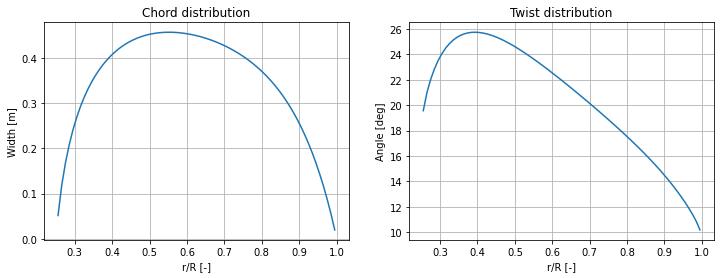

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.set_title('Chord distribution')
ax1.grid(True)
ax1.plot(centroids,-opt_c_dist)
ax1.set_xlabel('r/R [-]')
ax1.set_ylabel('Width [m]')


ax2.grid(True)
ax2.set_title('Twist distribution')
ax2.plot(centroids,twist_dist)
ax2.set_xlabel('r/R [-]')
ax2.set_ylabel('Angle [deg]')

fig.savefig('prop_chord_twist.png')

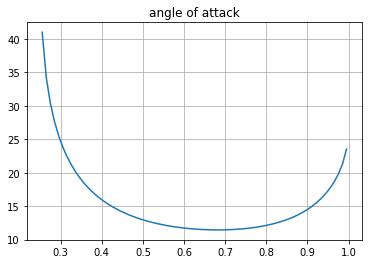

In [19]:

plt.figure()
plt.grid(True)
plt.title('angle of attack')
plt.plot(centroids,results[:,7])
